In [41]:
# Environment Variable Prep: for working with LM Studio model
import os

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'http://localhost:1234/v1'
os.environ['LANGCHAIN_API_KEY'] = 'lm-studio'
print(os.environ.get('LANGCHAIN_TRACING_V2'), os.environ.get('LANGCHAIN_ENDPOINT'), os.environ.get('LANGCHAIN_API_KEY'))

true http://localhost:1234/v1 lm-studio


In [3]:
# Load King James Bible as corups. There are 66 books in the Bible.
import pandas as pd

kjv_df = pd.read_csv('en_kjv.csv', index_col='index')
kjv_df.head()

,language,translation,book,chapter,verse,text
index,,,,,,
0,en,kjv,Gen,1,1,In the beginning God created the heaven and th...
1,en,kjv,Gen,1,2,"And the earth was without form, and void; and ..."
2,en,kjv,Gen,1,3,"And God said, Let there be light: and there wa..."
3,en,kjv,Gen,1,4,"And God saw the light, that it was good: and G..."
4,en,kjv,Gen,1,5,"And God called the light Day, and the darkness..."


In [8]:
# DELETE THIS LATER !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
text_df = kjv_df['text']
print(text_df.head())
texts = text_df.values
print(type(texts))
print(texts)

index
0    In the beginning God created the heaven and th...
1    And the earth was without form, and void; and ...
2    And God said, Let there be light: and there wa...
3    And God saw the light, that it was good: and G...
4    And God called the light Day, and the darkness...
Name: text, dtype: object
<class 'numpy.ndarray'>
['In the beginning God created the heaven and the earth.'
 'And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.'
 'And God said, Let there be light: and there was light.' ...
 'And if any man shall take away from the words of the book of this prophecy, God shall take away his part out of the book of life, and out of the holy city, and from the things which are written in this book.'
 'He which testifieth these things saith, Surely I come quickly. Amen. Even so, come, Lord Jesus.'
 'The grace of our Lord Jesus Christ be with you all. Amen.']


In [43]:
# The Bible is split into verses, so for now, there is no need to split the texts
test_question = 'What is the first verse in the Bible?'
test_verse = kjv_df.iloc[0]['text'] # In the beginning God created the heaven and the earth.
print(test_verse)

In the beginning God created the heaven and the earth.


In [53]:
# NLP on extracted verses
import tiktoken
import numpy as np
from scipy.stats import skew, kurtosis

def bible_verse_tokens(df, encoding_name):
    result = [] # To be returned
    book_count = ''
    for index, row in df.iterrows():
        book = row['book'] # Progress notice
        encoding = tiktoken.get_encoding(encoding_name)
        result.append(len(encoding.encode(row['text'])))
    return result

# Token length distribution analysis
verse_lengths = bible_verse_tokens(kjv_df, 'cl100k_base')
shortest_verse = np.min(verse_lengths)
longest_verse = np.max(verse_lengths)
verse_range = longest_verse - shortest_verse
verse_mean = round(np.mean(verse_lengths), 2)
verse_median = round(np.median(verse_lengths), 2)
verse_standard_dev = round(np.std(verse_lengths), 2)
verse_variance = round(np.var(verse_lengths), 2)
verse_skew = round(skew(verse_lengths), 2)
verse_kurt = round(kurtosis(verse_lengths), 2)
print("Min: {}\nMax: {}\nRange: {}\nMean: {}\nMedian: {}\nStDev: {}\nVariance: {}\nSkewedness: {}\nKurtosis: {}". \
      format(shortest_verse, longest_verse, verse_range, verse_mean, verse_median, verse_standard_dev, verse_variance, verse_skew, verse_kurt))

Min: 4
Max: 111
Range: 107
Mean: 32.05
Median: 30.0
StDev: 13.63
Variance: 185.82
Skewedness: 0.87
Kurtosis: 0.7


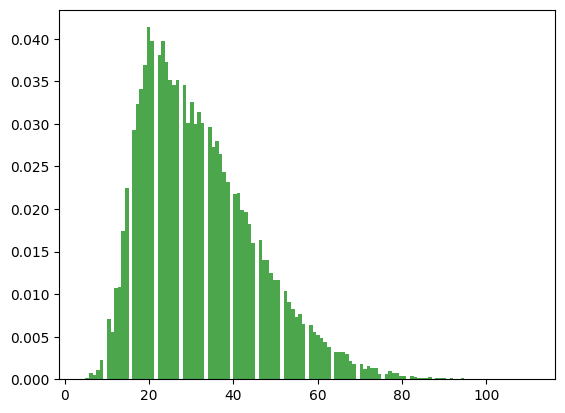

In [69]:
# Normal distribution of verse embedding lengths
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(verse_lengths, bins=125, density=True, alpha=0.7, color='g')
plt.show()

In [15]:
# Store verses in vector db
from langchain_core.documents import Document
from uuid import uuid4

# Arrange the verses as documents with metadata
def document_verses(df):
    documents = []
    count = 0
    for index, row in df.iterrows():
        count += 1
        doc = Document(
            page_content=row['text'],
            metadata={
                'title': row['book'],
                'chapter': row['chapter'],
                'verse': row['verse']
            },
            id=count
        )
        documents.append(doc)
    uuids = [str(uuid4()) for _ in range(len(documents))]
    return documents, uuids
verse_docs, verse_ids = document_verses(kjv_df)

In [17]:
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

# Store the vectorized documents
embeddings = OllamaEmbeddings(model='llama3')
vectorstore = Chroma(
    collection_name='Holy Bible: King James Version',
    embedding_function=embeddings,
    persist_directory='./chroma_kjv_db'
)
vectorstore.add_documents(documents=verse_docs, ids=verse_ids)

# Retrieve verses
retriever = vectorstore.as_retriever()

ValueError: Expected collection name that (1) contains 3-63 characters, (2) starts and ends with an alphanumeric character, (3) otherwise contains only alphanumeric characters, underscores or hyphens (-), (4) contains no two consecutive periods (..) and (5) is not a valid IPv4 address, got Holy Bible: King James Version